In [2]:
import numpy as np
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from parse_filenames import parse_filenames

In [3]:
path = Path.home() / 'Desktop' / 'disk2' / 'lfp_power_spectra_dump'

In [42]:
parsed_df = parse_filenames(path)
parsed_df

,sessionID,area,condition,running,flashesAveragedOver,micronsElectrodeDepth,filename
0,794812542,VISpm,toWhite,True,2,992.0,sessionID_794812542_area_VISpm_condition_toWhi...
1,742951821,VISp,toWhite,True,2,NaN,sessionID_742951821_area_VISp_condition_toWhit...
2,771990200,VISp,toBlack,True,14,1039.0,sessionID_771990200_area_VISp_condition_toBlac...
3,797828357,VISp,toWhite,True,9,1046.0,sessionID_797828357_area_VISp_condition_toWhit...
4,797828357,VISp,toWhite,False,66,1046.0,sessionID_797828357_area_VISp_condition_toWhit...
...,...,...,...,...,...,...,...
150,715093703,VISp,toWhite,False,14,NaN,sessionID_715093703_area_VISp_condition_toWhit...
151,771160300,VISp,toWhite,True,29,1135.0,sessionID_771160300_area_VISp_condition_toWhit...
152,719161530,VISp,toWhite,False,17,762.0,sessionID_719161530_area_VISp_condition_toWhit...
153,761418226,VISpm,toBlack,False,74,1165.0,sessionID_761418226_area_VISpm_condition_toBla...


In [43]:
# Deleting rows without 8 conditions

for sid in parsed_df.sessionID.unique():
    if len(parsed_df[parsed_df.sessionID==sid]) != 8:
        parsed_df = parsed_df.drop(parsed_df[parsed_df.sessionID==sid].index)

In [44]:
conditions = [('VISpm', 'toWhite', True), ('VISpm', 'toBlack', True), ('VISpm', 'toWhite', False), ('VISpm', 'toBlack', False),
             ('VISp', 'toWhite', True), ('VISp', 'toBlack', True), ('VISp', 'toWhite', False), ('VISp', 'toBlack', False)]

for condition in conditions:
    selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
    print(condition, len(selected_df))

('VISpm', 'toWhite', True) 19
('VISpm', 'toBlack', True) 19
('VISpm', 'toWhite', False) 19
('VISpm', 'toBlack', False) 19
('VISp', 'toWhite', True) 19
('VISp', 'toBlack', True) 19
('VISp', 'toWhite', False) 19
('VISp', 'toBlack', False) 19


In [45]:
parsed_df

,sessionID,area,condition,running,flashesAveragedOver,micronsElectrodeDepth,filename
1,742951821,VISp,toWhite,True,2,NaN,sessionID_742951821_area_VISp_condition_toWhit...
2,771990200,VISp,toBlack,True,14,1039.0,sessionID_771990200_area_VISp_condition_toBlac...
3,797828357,VISp,toWhite,True,9,1046.0,sessionID_797828357_area_VISp_condition_toWhit...
4,797828357,VISp,toWhite,False,66,1046.0,sessionID_797828357_area_VISp_condition_toWhit...
5,771990200,VISpm,toWhite,False,63,985.0,sessionID_771990200_area_VISpm_condition_toWhi...
...,...,...,...,...,...,...,...
150,715093703,VISp,toWhite,False,14,NaN,sessionID_715093703_area_VISp_condition_toWhit...
151,771160300,VISp,toWhite,True,29,1135.0,sessionID_771160300_area_VISp_condition_toWhit...
152,719161530,VISp,toWhite,False,17,762.0,sessionID_719161530_area_VISp_condition_toWhit...
153,761418226,VISpm,toBlack,False,74,1165.0,sessionID_761418226_area_VISpm_condition_toBla...


In [48]:
sid = 771160300

pss = []

for condition in conditions:
    selected_df = parsed_df[(parsed_df.sessionID==sid) & (parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
    loaded_list = np.load(path/selected_df.filename.item())
    pss.append(loaded_list)

f = pss[0][0]

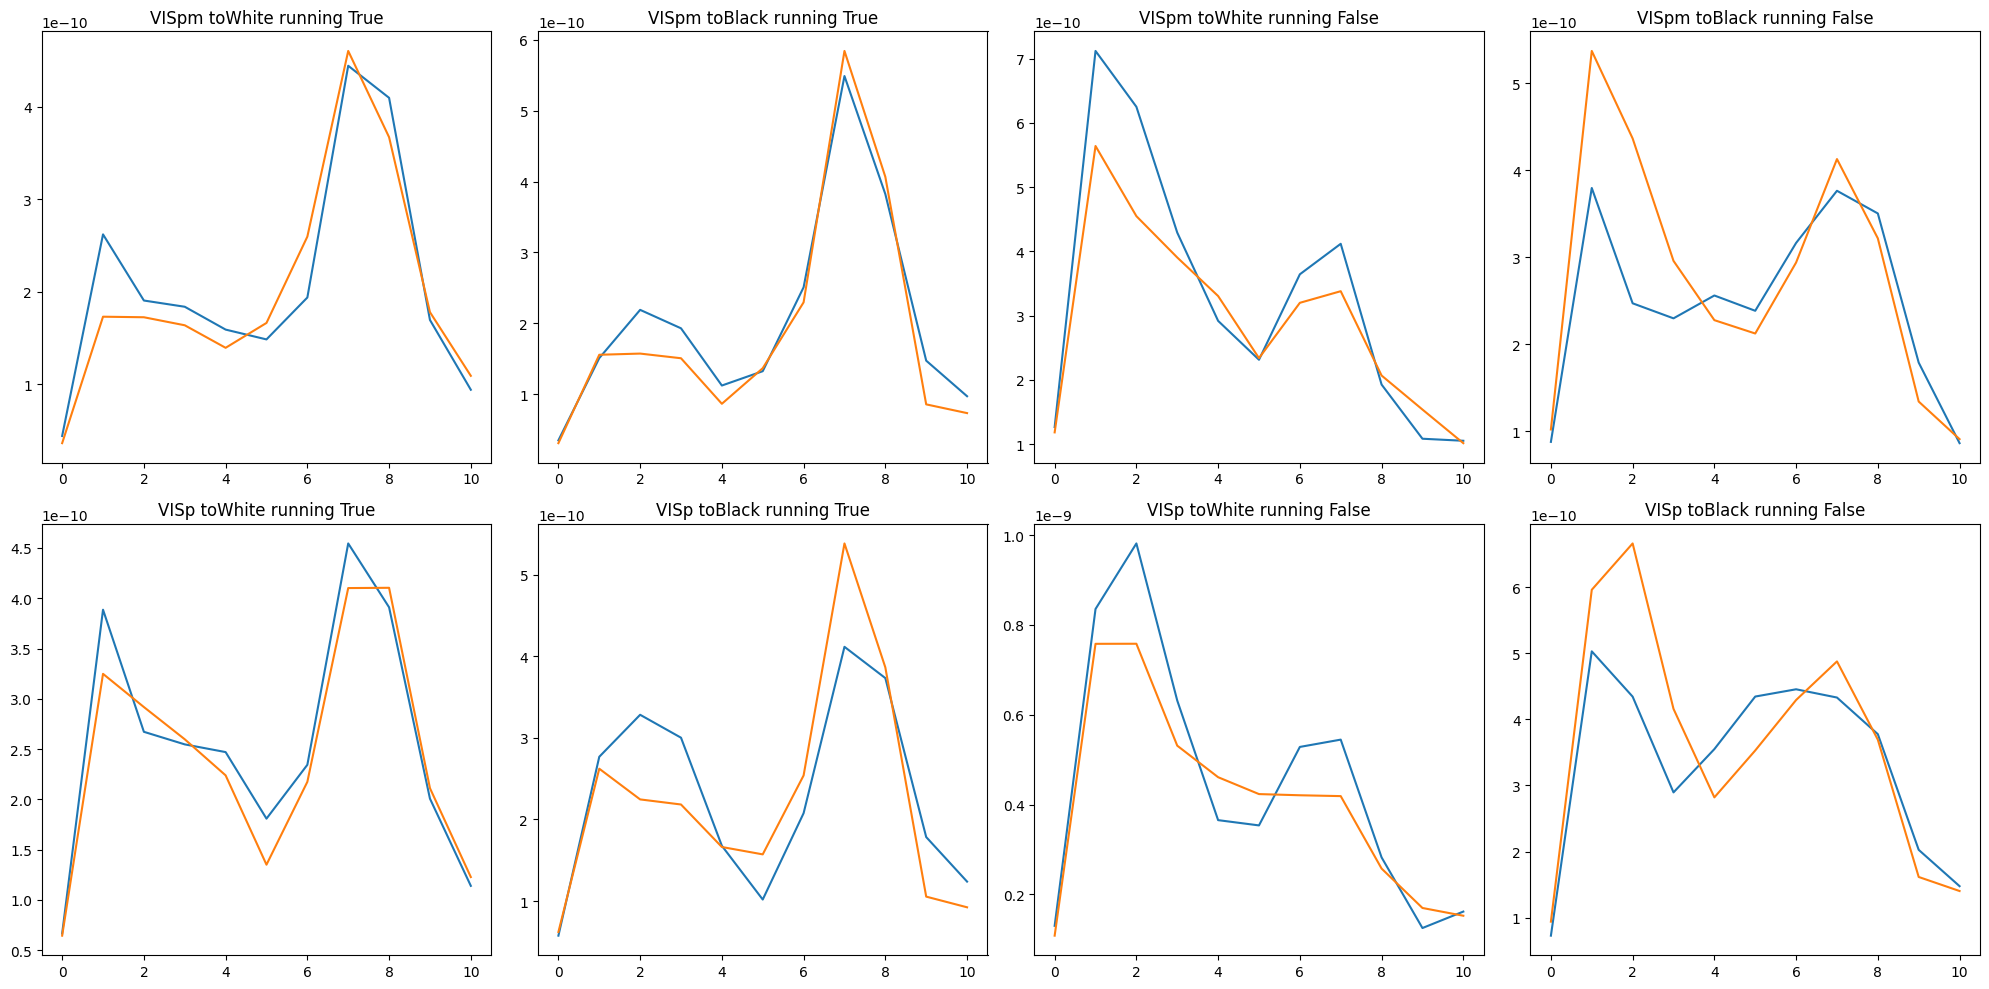

In [49]:
# One session's power spectra

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,10))

for i in range(4):
    ax[0][i].plot(f,pss[i][1])
    ax[0][i].plot(f,pss[i][2])
    ax[0][i].set_title(f'{conditions[i][0]} {conditions[i][1]} running {conditions[i][2]}')
    
for i in range(4):
    ax[1][i].plot(f,pss[4+i][1])
    ax[1][i].plot(f,pss[4+i][2])
    ax[1][i].set_title(f'{conditions[4+i][0]} {conditions[4+i][1]} running {conditions[4+i][2]}')
    
plt.tight_layout()
plt.show()